# Detecting the Sudoku Grid
## This notebook is composed to demonstrate the underlying operations of detectsudoku.py
## The pipeline of the image processing is as follows:
1. Preprocessing
    1. Make the image grayscale
    2. Apply gaussian blur
    3. Use adaptive thresholding
2. Finding the corners of the sudoku grid
    1. Find all external contours
    2. Take the biggest area contour
    3. Approximate the contour using a polygon
    4. Check if the polygon is a rectangle
    5. If so, take the corners of the rectangle
3. Extracting numbers from the grid
    1. Perform metric rectification on the grid
    2. Apply adaptive thresholding
    3. Divide the image into 81 cells
    4. Crop the edges of each cell
    5. Apply blur to each cell

The cell below loads some sample sudoku puzzle images.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

def load_image(url):
  response = requests.get(url)
  image_bytes = BytesIO(response.content)
  image_array = np.asarray(bytearray(image_bytes.read()), dtype=np.uint8)
  image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)[:, :, ::-1]
  return image

base_url = 'https://raw.githubusercontent.com/boraculhan/CVassignment/main/'
image_str = ['IMG_8904.jpeg', 'IMG_8905.jpeg', 'IMG_8906.jpeg', 'IMG_8907.jpeg']

image_data = list()
for image in image_str:
  image_data.append(load_image(base_url + image))


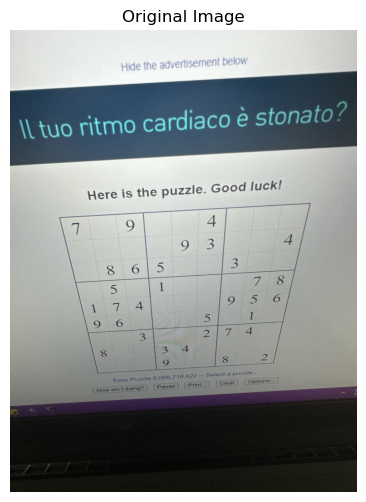

In [2]:
# We have uploaded 4 different images. Feel free to chande the index to try out with different images.
img = image_data[2]
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Original Image');

In [3]:
def preprocess_image(img):
    # Make the image grayscale. Blur the image. Apply thresholding
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return thresh

def find_sudoku_grid(binary_image):
    # Find only the "external" contours to discard the sudoku cell contours
    # Then, find the contour with the biggest area
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    best_cnt = None
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 10:  # Filter out small contours that could not be the grid
            if area > max_area:
                max_area = area
                best_cnt = cnt
    return best_cnt

def perspective_transform(image, contour):
    # Approximate the contour using a polygon and check that it forms a rectangle
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        # Get the points in the correct order
        pts1 = np.float32([approx[0][0], approx[1][0], approx[2][0], approx[3][0]])
        # Sort points by the y value to ensure the correct orientation of the sudoku grid
        pts1 = pts1[np.argsort(pts1[:, 1])]
        if pts1[0][0] > pts1[1][0]:
            pts1[[0, 1]] = pts1[[1, 0]]
        if pts1[2][0] < pts1[3][0]:
            pts1[[2, 3]] = pts1[[3, 2]]

        # Define points to warp
        # Each side is 28*9 because this image will be divided into 81 cells of size 28 by 28
        side = 28*9
        pts2 = np.float32([[0, 0], [side-1, 0], [side-1, side-1], [0, side-1]])
        corresponding_pairs = list()
        for i in range(4):
            corresponding_pairs.append((pts1[i], pts2[i]))
        A = np.zeros((8, 9))
        for i, pair in enumerate(corresponding_pairs):
            a, o = pair
            A[2*i] =   [-a[0], -a[1], -1, 0, 0, 0, a[0]*o[0], a[1]*o[0], o[0]]
            A[2*i+1] = [0, 0, 0, -a[0], -a[1], -1, a[0]*o[1], a[1]*o[1], o[1]]

        _, _, vt = np.linalg.svd(A)
        H = vt[-1].reshape((3,3)); H = H/H[-1, -1]

        # Apply the warp
        dst = cv2.warpPerspective(image, H, (int(side), int(side)))
        return dst, H, pts1
    return None, None, None  # In case the contour is not a quadrilateral

def split_into_cells(grid_image):
  # Take the rectified image and divide it  into 81 cells
    cells = []
    size = grid_image.shape[0] // 9
    for i in range(9):
        row = []
        for j in range(9):
            cell = grid_image[i*size:(i+1)*size, j*size:(j+1)*size]
            row.append(cell)
        cells.append(row)
    return cells

def remove_outer_ring(input_images_matrix):
    images_matrix = input_images_matrix.copy()
    ring_width = 5
    # Use numpy slicing to set the outer ring of pixels to black
    images_matrix[:, :, :ring_width, :] = 0  # Top edge
    images_matrix[:, :, -ring_width:, :] = 0  # Bottom edge
    images_matrix[:, :, :, :ring_width] = 0  # Left edge
    images_matrix[:, :, :, -ring_width:] = 0  # Right edge
    return images_matrix

def apply_blur_to_cells(input_images_matrix):
  # Apply blur to each cell in the matrix containing the cells
    matrix = input_images_matrix.copy()
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            matrix[row, col] = cv2.GaussianBlur(matrix[row, col], (3, 3), -5)
    return matrix

class DetectSudoku():
    """

    Usage: Reads the image in the specified path and detects the sudoku puzzle and extracts
    the cells of which a number exists.

    """
    def __init__(self, img):
        self.img = img

    def GetCells(self, testing = True):
        processed_image = preprocess_image(self.img)
        contour = find_sudoku_grid(processed_image)

        if contour is not None:
            flat_grid_image, H, corners = perspective_transform(self.img, contour)
            if flat_grid_image is None:
                raise ValueError('Could not find a rectangular contour')
            gray = cv2.cvtColor(flat_grid_image, cv2.COLOR_BGR2GRAY)
            flat_grid_image_thresh = 255- cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 10)
            if flat_grid_image is not None:
                cells = np.array(split_into_cells(flat_grid_image))
                cells_thresh = np.array(split_into_cells(flat_grid_image_thresh))
                cells_thresh_cropped = remove_outer_ring(cells_thresh)
                cells_thresh_cropped_blurred = apply_blur_to_cells(cells_thresh_cropped)

                print("Cells extracted")
            else:
                print("Could not perform perspective transformation.")
        else:
            print("No Sudoku grid found.")
        if testing:
            return cells, cells_thresh, cells_thresh_cropped, cells_thresh_cropped_blurred, flat_grid_image_thresh, H, self.img, processed_image, contour, flat_grid_image, corners
        else:
            return cells_thresh_cropped_blurred, H

Cells extracted


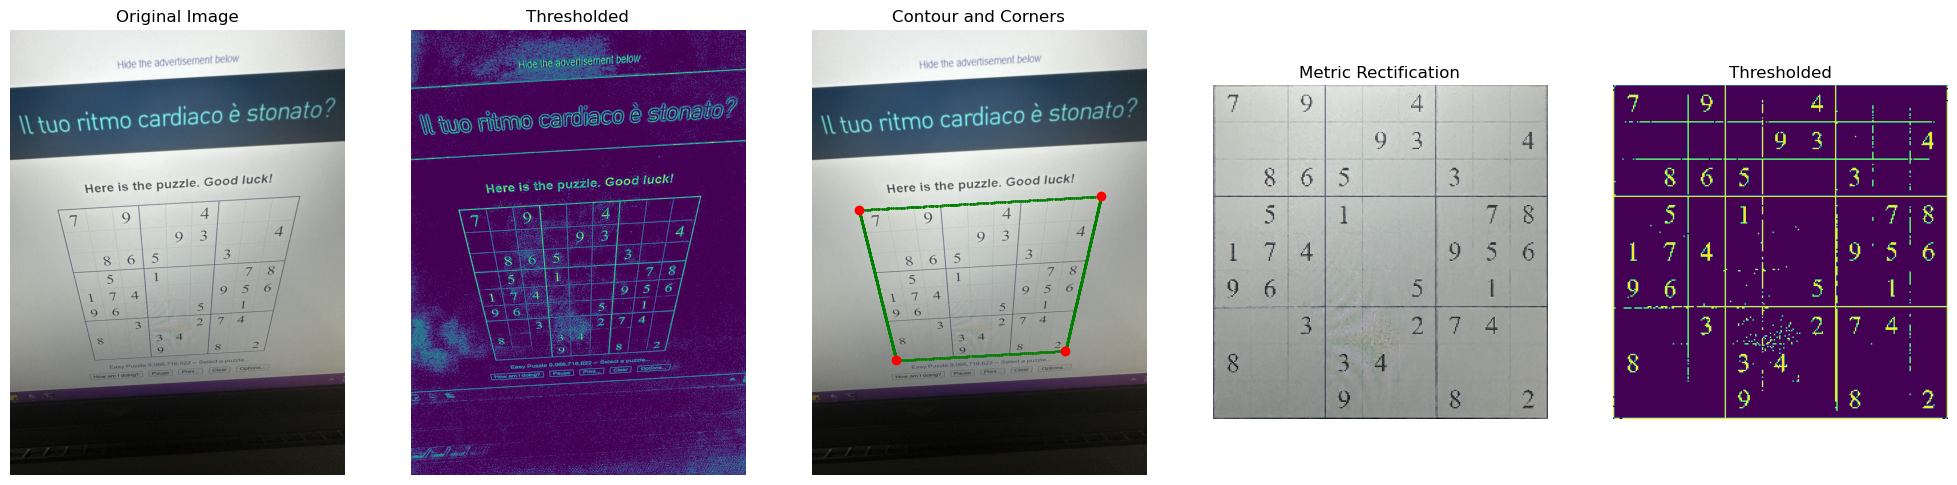

In [4]:
b = DetectSudoku(img)
out1, out2, out3, out4, out5, out6, out7, out8, out9, out10, out11 = b.GetCells()

subplots = 5
plt.figure(figsize=(25,25))
plt.subplot(1, subplots, 1)
plt.axis('off')
plt.title("Original Image")
plt.imshow(out7)
plt.subplot(1, subplots, 2)
plt.axis('off')
plt.title("Thresholded")
plt.imshow(out8)
plt.subplot(1, subplots, 3)
plt.axis('off')
plt.title("Contour and Corners")
plt.imshow(out7)
plt.scatter(out9[:, :, 0], out9[:, :, 1], color='green', s=0.5)
plt.scatter(out11[:, 0], out11[:, 1], color="red")
plt.subplot(1, subplots, 4)
plt.axis('off')
plt.title("Metric Rectification")
plt.imshow(out10)
plt.subplot(1, subplots, 5)
plt.axis('off')
plt.title("Thresholded")
plt.imshow(out5);

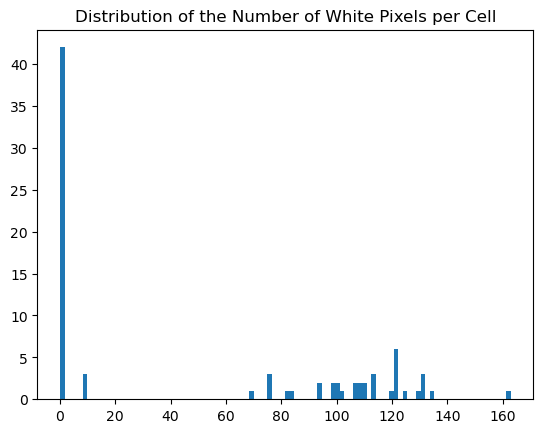

In [5]:
white_pixels_in_img = []
for i in range(9):
    for j in range(9):
        white_pixels_in_img += [cv2.countNonZero(out4[i][j])]
plt.title("Distribution of the Number of White Pixels per Cell")
plt.hist(white_pixels_in_img, bins=100);

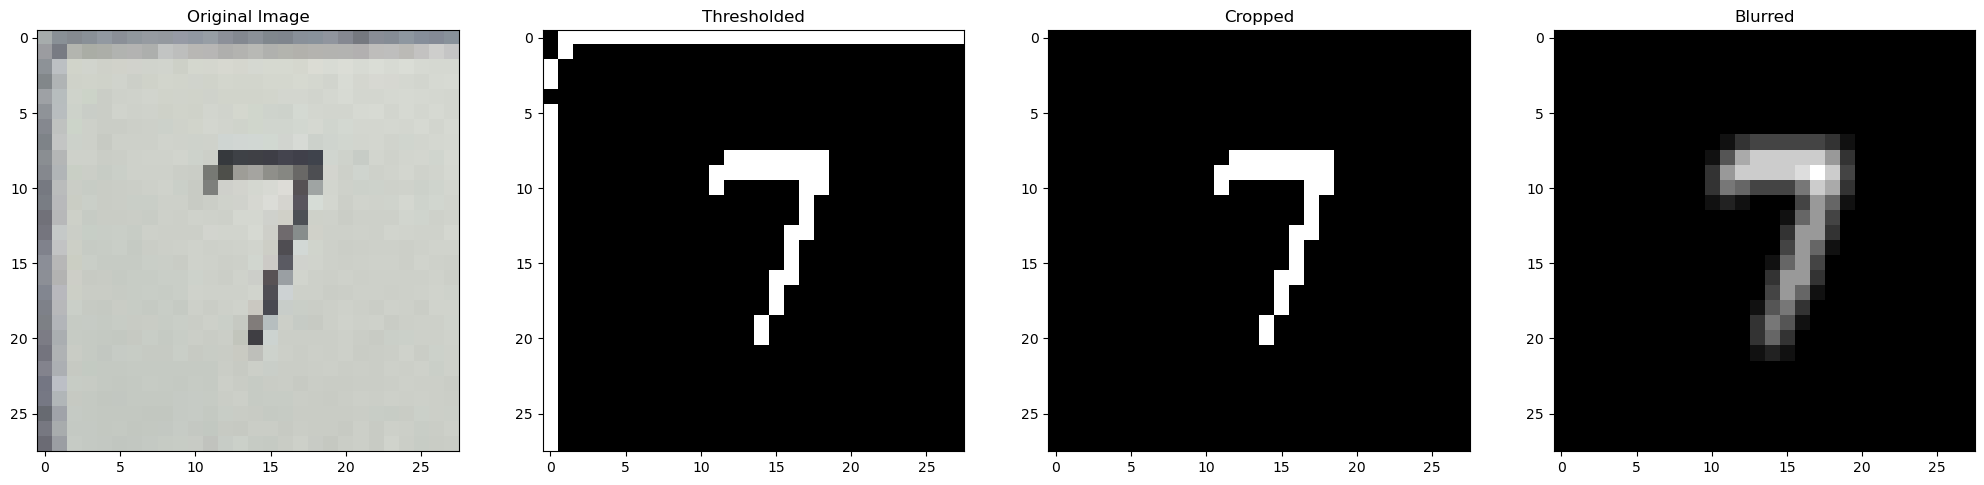

In [6]:
i,j = 0,0
subplots = 4
plt.figure(figsize=(25,25))

plt.subplot(1, subplots, 1)
plt.title("Original Image")
plt.imshow(out1[i][j])
plt.subplot(1, subplots, 2)
plt.title("Thresholded")
plt.imshow(out2[i][j], cmap="gray")
plt.subplot(1, subplots, 3)
plt.title("Cropped")
plt.imshow(out3[i][j], cmap="gray")
plt.subplot(1, subplots, 4)
plt.title("Blurred")
plt.imshow(out4[i][j], cmap="gray");